# Correlation analysis between the Cardano currency and Twitter

This project consists of a correlation analysis between the Cardano currency and tweets. In order to define the positiveness of a tweet (if the course of the cardano will go up or down), we realise a sentiment analysis of each tweet using the VADER algorithm. Finally we try to find a correlation between the two and we will make some machine learning to make predictions.

This notebook was written using Python 3.6.

## Import the Python dependencies
For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

```
pip install VaderSentiment
pip install pandas
pip install tqdm
...
```

You can also run `pip install .` from the project's root folder to install all the requirements from the `requirements.txt` file.

In [33]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta

## Set the currency and the data files

In [34]:
# Define the currency
CURRENCY = ""
CURRENCY_SYMBOL = ""

CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
TWITTER_FOLDER = f"data/twitter/{CURRENCY_SYMBOL}"

#tweets_clean_file = f'{TWITTER_FOLDER}/{CURRENCY}_tweets_clean.csv'

## Load the datasets

We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The extraction process is detailed in these notebooks so please refer to them for any information needed. Here we simply gather all the extracted data to generate two datasets :

- The twitter dataset : contains historical tweets related to the targeted crypto currency with a sentiment score.
- The crypo dataset : contains historical data of the crypto currency we target with the change in USD.

### Twitter dataset

The data is split into multiple files. Here it is gathered into a single dataframe.

In [35]:
#tweets = pd.read_csv(tweets_clean_file)
twitter_files = glob.glob(f"{TWITTER_FOLDER}/*~*.csv")
twitter_files = sorted(twitter_files)

dfs = []
for file in twitter_files:
    dfs.append(pd.read_csv(file))
tweets = pd.concat(dfs)
#tweets = tweets.sort_values(by=['ID'])

# Drop duplicate tweets
print('tweet shape before droping duplicates', tweets.shape)
duplicates_removed = tweets.shape[0]
tweets = tweets.drop_duplicates(subset=['ID'])
duplicates_removed -= tweets.shape[0]
print('tweet shape after droping duplicates', tweets.shape)
print('duplicates removed', duplicates_removed)

# Display dataframes head
tweets.head(2)

tweet shape before droping duplicates (180432, 9)
tweet shape after droping duplicates (109096, 9)
duplicates removed 71336


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,score
0,1421296095452450819,"I sold all NFTs coins, profit was pretty good....",Megalodon,156,0,4,Sat Jul 31 02:26:10 +0000 2021,0.9450,737.100
2,1421296350176583686,RT : The Galgos | CNFT | NFTGiveaway NFTs NFTC...,Ahloe Desq,123,133,0,Sat Jul 31 02:27:10 +0000 2021,0.5255,8661.291


### Crypto dataset

In [36]:
crypto_usd = pd.read_csv("data/crypto/ADA/ADA.csv")
crypto_usd.head()

,open,high,low,close,volume,time
0,1.3109,1.3141,1.3094,1.3094,722172.84,1627689600
1,1.3094,1.3127,1.3059,1.3062,441102.14,1627689660
2,1.3061,1.3087,1.3045,1.3052,849141.24,1627689720
3,1.3052,1.3081,1.3040,1.3068,351830.14,1627689780
4,1.3066,1.3077,1.3026,1.3026,222940.12,1627689840


In [37]:
crypto_usd = crypto_usd.sort_values(by=['time'])

In [38]:
# Drop duplicates
print('cardano shape before droping duplicates', crypto_usd.shape)
duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
print('cardano shape after droping duplicates', crypto_usd.shape)
duplicates_removed -= crypto_usd.shape[0]
print('duplicates removed', duplicates_removed)
crypto_usd.head(2)

cardano shape before droping duplicates (11521, 6)
cardano shape after droping duplicates (11521, 6)
duplicates removed 0


,open,high,low,close,volume,time
0,1.3109,1.3141,1.3094,1.3094,722172.84,1627689600
1,1.3094,1.3127,1.3059,1.3062,441102.14,1627689660


## Group by and sum by timeframe

In [39]:
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'],utc=True)
tweets.CreatedAt = tweets.CreatedAt.dt.tz_localize(None)
tweets.index = tweets['CreatedAt']

tweets_grouped = tweets.groupby(pd.Grouper(freq = 'H'))['score'].sum()

crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s')
crypto_usd.index = crypto_usd['time']

crypto_usd_grouped = crypto_usd.groupby(pd.Grouper(freq = 'H'))['close'].mean()

In [40]:
crypto_usd_grouped.to_csv(f'data/crypto/{CURRENCY}_currency_grouped.csv')
tweets_grouped.to_csv(f'data/crypto/{CURRENCY}_tweets_grouped.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### Plotting the scores
We calculate the mean of each tweets grouped by hour and then we plot it.

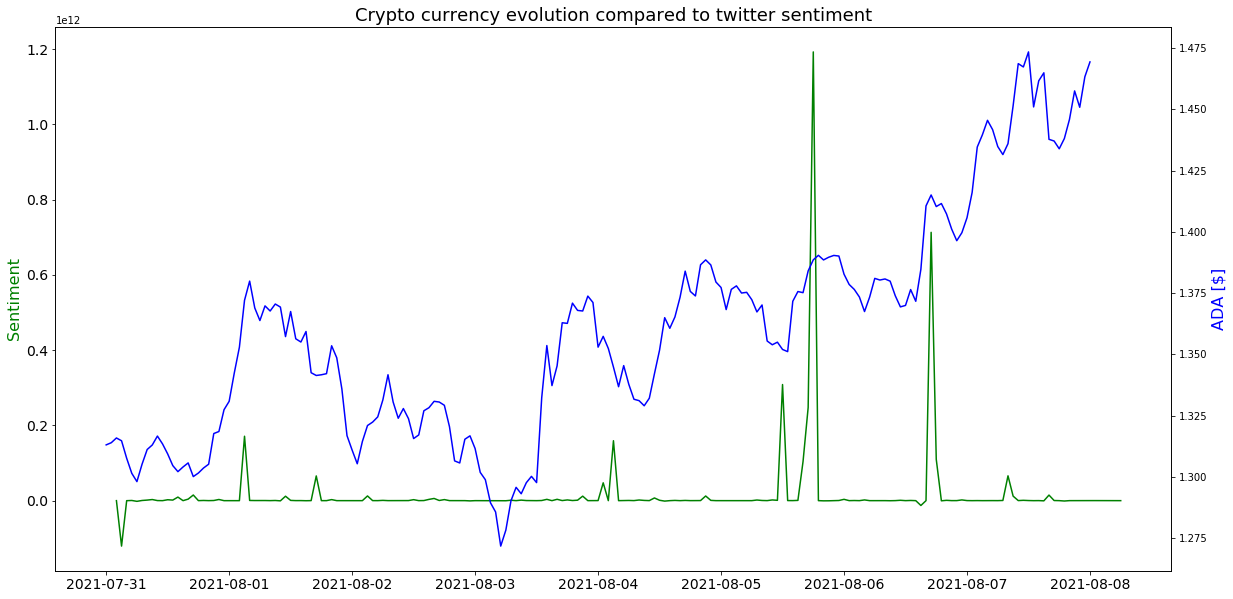

In [41]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

## Correlation analysis
Here we make the correlation analysis between ADA/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series.
https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [42]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

### Crop the time series to match the time frames

In [43]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

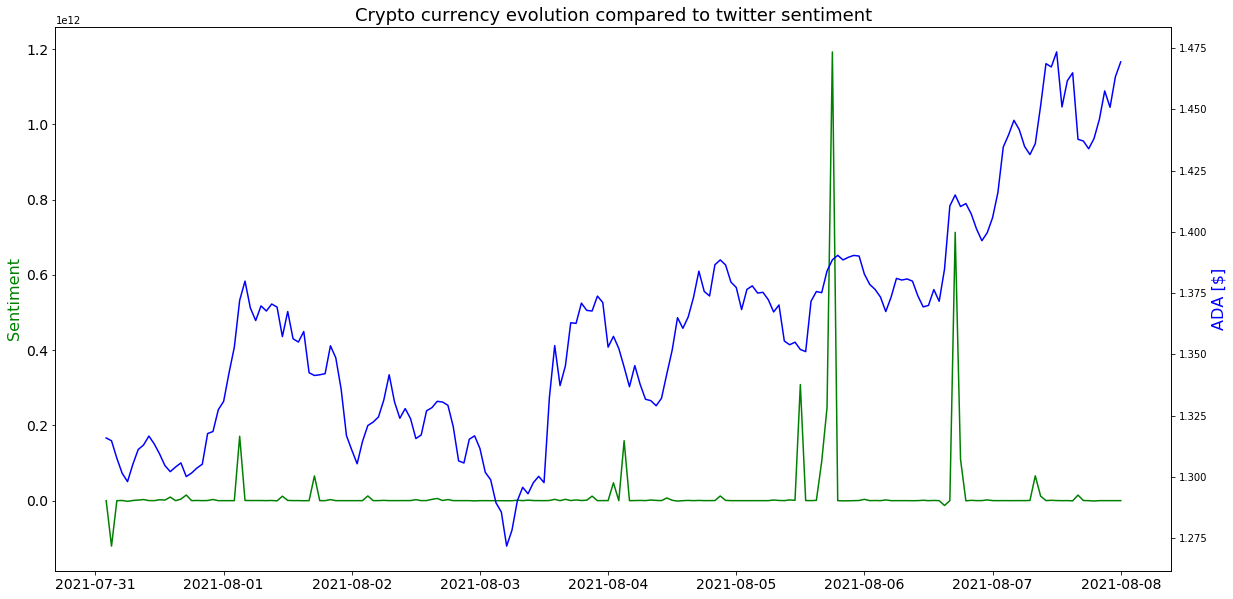

In [44]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

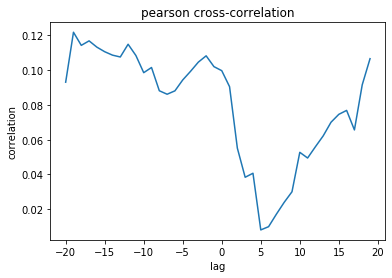

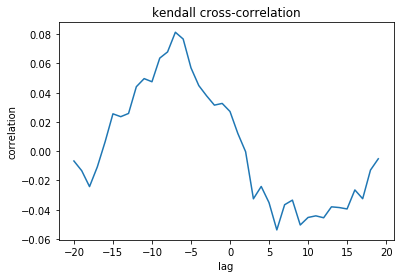

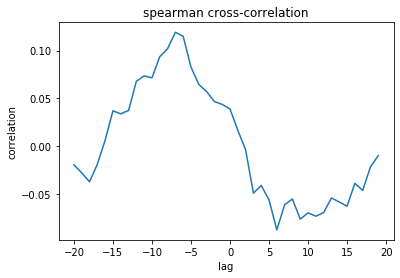

In [45]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize 
First we need to normalize the data.

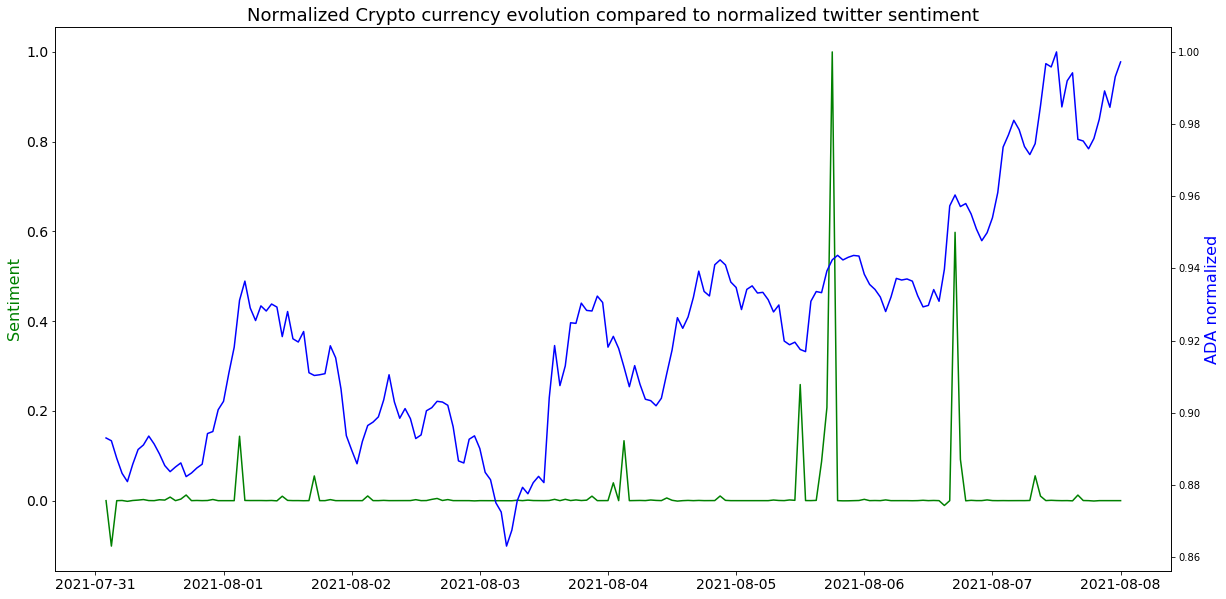

In [46]:
# Normalize time series data
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} normalized", color='b', fontsize=16)
plt.show()

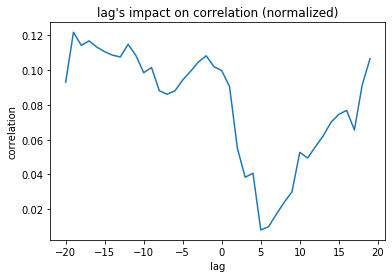

In [47]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Calculate derivative

The derivative is calculated to define an increase or a decrease of the crypto currency.

The score is as well derivated to observe the increase or decrease of the score.

Computing the derivative could help to find a correlation.

In [48]:
# Derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

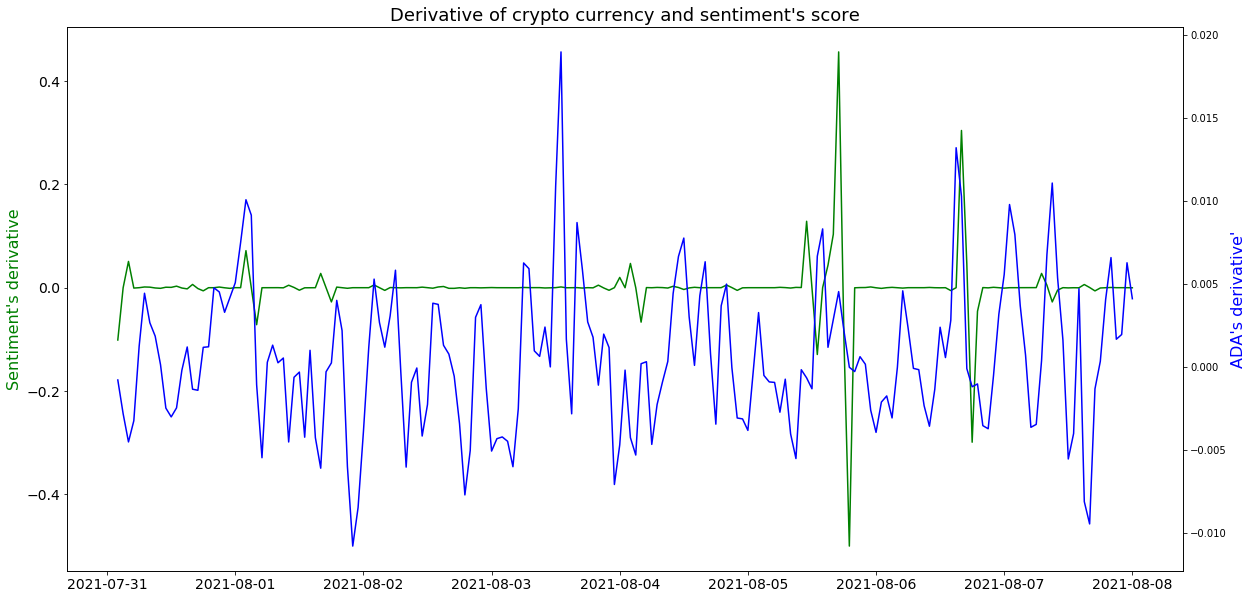

In [49]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL}'s derivative'", color='b', fontsize=16)
plt.show()

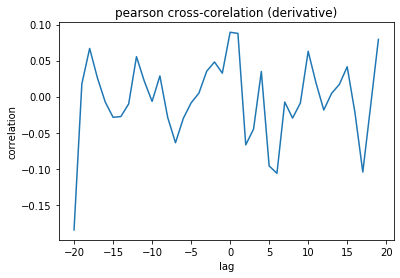

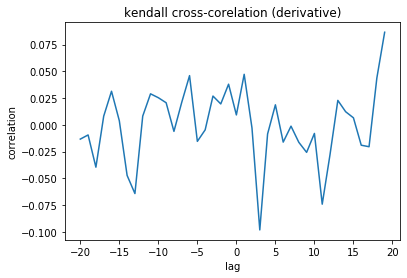

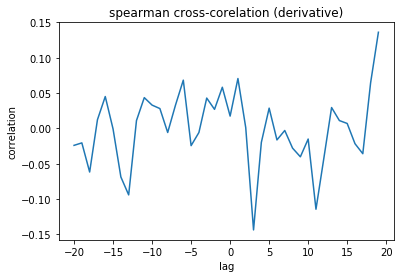

In [50]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()